In [20]:
import cv2
import os
import numpy as np
import pandas as pd

from functools import reduce

from pybalu.io import imread
from pybalu.feature_extraction import lbp_features
# from pybalu.feature_selection import clean, sfs
# from pybalu.feature_transformation import normalize, pca

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# 2) Usar solo las primeras 16 personas de las base de datos.
DATASET = 'FaceMask166'

images_names = sorted([i for i in os.listdir(DATASET) if i.endswith('jpg')])
# images_names.sort()

images_names = images_names[:96]
print(images_names)

['FM000001_01.jpg', 'FM000001_02.jpg', 'FM000001_03.jpg', 'FM000001_04.jpg', 'FM000001_05.jpg', 'FM000001_06.jpg', 'FM000002_01.jpg', 'FM000002_02.jpg', 'FM000002_03.jpg', 'FM000002_04.jpg', 'FM000002_05.jpg', 'FM000002_06.jpg', 'FM000003_01.jpg', 'FM000003_02.jpg', 'FM000003_03.jpg', 'FM000003_04.jpg', 'FM000003_05.jpg', 'FM000003_06.jpg', 'FM000004_01.jpg', 'FM000004_02.jpg', 'FM000004_03.jpg', 'FM000004_04.jpg', 'FM000004_05.jpg', 'FM000004_06.jpg', 'FM000005_01.jpg', 'FM000005_02.jpg', 'FM000005_03.jpg', 'FM000005_04.jpg', 'FM000005_05.jpg', 'FM000005_06.jpg', 'FM000006_01.jpg', 'FM000006_02.jpg', 'FM000006_03.jpg', 'FM000006_04.jpg', 'FM000006_05.jpg', 'FM000006_06.jpg', 'FM000007_01.jpg', 'FM000007_02.jpg', 'FM000007_03.jpg', 'FM000007_04.jpg', 'FM000007_05.jpg', 'FM000007_06.jpg', 'FM000008_01.jpg', 'FM000008_02.jpg', 'FM000008_03.jpg', 'FM000008_04.jpg', 'FM000008_05.jpg', 'FM000008_06.jpg', 'FM000009_01.jpg', 'FM000009_02.jpg', 'FM000009_03.jpg', 'FM000009_04.jpg', 'FM000009_0

In [50]:
# 3) Generar una nueva base de datos con las imágenes en blanco y negro y recortarlas de tal forma que solo aparezca la mitad superior de la foto original, es decir la foto debe tener 128 x 256 pixeles, debe estar en blanco y negro.

def open_image(image_path):
    image = cv2.imread(f'{DATASET}/{image_path}')
    return image

train_names = sorted([i for i in images_names if (i.endswith('01.jpg') or i.endswith('02.jpg') or i.endswith('03.jpg')) ])
validation_names = sorted([i for i in images_names if i.endswith('04.jpg') ])
test_names = sorted([i for i in images_names if (i.endswith('05.jpg') or i.endswith('06.jpg')) ])

y_train = [image_name.split('_')[0] for image_name in train_names]
y_val = [image_name.split('_')[0] for image_name in validation_names]
y_test = [image_name.split('_')[0] for image_name in test_names]

print(y_train)

x_train = [open_image(image_path)[:128,:] for image_path in train_names]
x_val = [open_image(image_path)[:128,:] for image_path in validation_names]
x_test = [open_image(image_path)[:128,:] for image_path in test_names]

# print(x_train[0])

['FM000001', 'FM000001', 'FM000001', 'FM000002', 'FM000002', 'FM000002', 'FM000003', 'FM000003', 'FM000003', 'FM000004', 'FM000004', 'FM000004', 'FM000005', 'FM000005', 'FM000005', 'FM000006', 'FM000006', 'FM000006', 'FM000007', 'FM000007', 'FM000007', 'FM000008', 'FM000008', 'FM000008', 'FM000009', 'FM000009', 'FM000009', 'FM000010', 'FM000010', 'FM000010', 'FM000011', 'FM000011', 'FM000011', 'FM000012', 'FM000012', 'FM000012', 'FM000013', 'FM000013', 'FM000013', 'FM000014', 'FM000014', 'FM000014', 'FM000015', 'FM000015', 'FM000015', 'FM000016', 'FM000016', 'FM000016']


(128, 256)


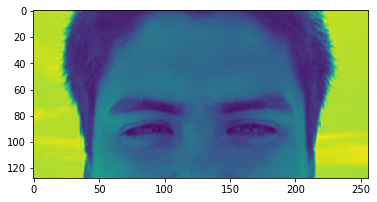

In [27]:
print(x_train[0].shape)
imgplot = plt.imshow(x_train[0])
plt.show()

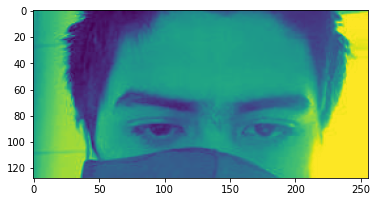

In [48]:
imgplot = plt.imshow(x_val[0])
plt.show()

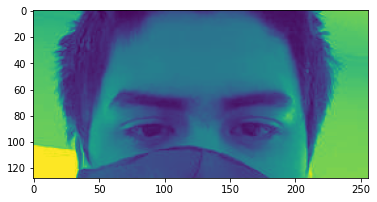

In [49]:
imgplot = plt.imshow(x_test[0])
plt.show()

In [103]:
# 4) Extraer LBP de 59 elementos usando 'n' particiones verticales y 'm' particiones horizontales, como por ejemplo n=4, y m=8.

def extract_features(images):
    lbp_bw_1_1 = np.array([lbp_features(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), hdiv=1, vdiv=1, mapping='nri_uniform') for img in images])
    lbp_bw_2_2 = np.array([lbp_features(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), hdiv=2, vdiv=2, mapping='nri_uniform') for img in images])
    lbp_bw_4_8 = np.array([lbp_features(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), hdiv=4, vdiv=8, mapping='nri_uniform') for img in images])
    lbp_bw_8_4 = np.array([lbp_features(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), vdiv=8, hdiv=4, mapping='nri_uniform') for img in images])
    
    lbp_red_1_1 = np.array([lbp_features(img[:, :, 0], hdiv=1, vdiv=1, mapping='nri_uniform') for img in images])
    lbp_green_1_1 = np.array([lbp_features(img[:, :, 1], hdiv=1, vdiv=1, mapping='nri_uniform') for img in images])
    lbp_blue_1_1 = np.array([lbp_features(img[:, :, 2], hdiv=1, vdiv=1, mapping='nri_uniform') for img in images])

    lbp_red_8_4 = np.array([lbp_features(img[:, :, 0], hdiv=8, vdiv=4, mapping='nri_uniform') for img in images])
    lbp_green_8_4 = np.array([lbp_features(img[:, :, 1], hdiv=8, vdiv=4, mapping='nri_uniform') for img in images])
    lbp_blue_8_4 = np.array([lbp_features(img[:, :, 2], hdiv=8, vdiv=4, mapping='nri_uniform') for img in images])


    features = {}
    features['lbp_bw_1_1'] = lbp_bw_1_1
    features['lbp_bw_2_2'] = lbp_bw_2_2
    features['lbp_bw_4_8'] = lbp_bw_4_8
    features['lbp_bw_8_4'] = lbp_bw_8_4

    features['lbp_red_1_1'] = lbp_red_1_1
    features['lbp_green_1_1'] = lbp_green_1_1
    features['lbp_blue_1_1'] = lbp_blue_1_1

    features['lbp_red_8_4'] = lbp_red_8_4
    features['lbp_green_8_4'] = lbp_green_8_4
    features['lbp_blue_8_4'] = lbp_blue_8_4

    return features

print(x_train[0].shape)

features_train = extract_features(x_train)
features_val = extract_features(x_val)
features_test = extract_features(x_test)

(128, 256, 3)


In [89]:
def get_classifier(classifier):
    classifiers = {
        'knn': KNeighborsClassifier(n_neighbors=3),
        'svm': SVC(kernel='sigmoid', gamma=0.01, C=0.01),
        'ada': AdaBoostClassifier(n_estimators=100)
    }

    return classifiers[classifier]

# KNN 3
def process(classifier_type, x_train, y_train, x_test, y_test, print_matrix=True):
    classifier = get_classifier(classifier_type)
    classifier.fit(x_train, y_train)

    train_pred = classifier.predict(x_train)
    test_pred = classifier.predict(x_test)

    train_accuracy = accuracy_score(y_train, train_pred) * 100
    test_accuracy = accuracy_score(y_test, test_pred) * 100

    conf_matrix = confusion_matrix(y_test, test_pred)

    print(f'\nTrain Accuracy: {train_accuracy}')
    print(f'Test Accuracy: {test_accuracy}\n')

    if print_matrix:
        print(conf_matrix)

# Parte práctica

### 6) Probar distintos clasificadores (y distintas particiones n,m)  entrenando con las primeras 3 fotos por persona y probando con la cuarta foto de la persona (no olvidar que las tres primeras fotos de cada persona son el set de entrenamiento, y que la cuarta foto es el set de validación).

Primero probamos con LPB de n=8, m=4 y probamos con los siguientes clasificadores:

- KNN(3):
    - accuracy train: 75,0%
    - accuracy validación: 56,25%
- SVM:
    - accuracy train: 6,25%
    - accuracy validación: 6,25%
- AdaBoost:
    - accuracy train: 62.5%
    - accuracy validación: 6.25%

Luego probamos con LPB de n=1, m=1 y probamos con los siguientes clasificadores:

- KNN(3):
    - accuracy train: 64,58%
    - accuracy validación: 12,5%
- SVM:
    - accuracy train: 6,25%
    - accuracy validación: 6,25%
- AdaBoost:
    - accuracy train: 25.0%
    - accuracy validación: 18.75%

Finalmente probamos con LPB de n=2, m=2 y probamos con los siguientes clasificadores:

- KNN(3):
    - accuracy train: 72,9%
    - accuracy validación: 43,75%
- SVM:
    - accuracy train: 6,25%
    - accuracy validación: 6,25%
- AdaBoost:
    - accuracy train: 18.75%
    - accuracy validación: 12.5%

A continuación está el código usado para cada clasificador, destacar que ese "Test accuracy" en este caso es el accuracy de validación

In [97]:
x_train_features =  np.concatenate((features_train['lbp_bw_8_4'],), axis=1)
x_val_features =  np.concatenate((features_val['lbp_bw_8_4'],), axis=1)
x_test_features =  np.concatenate((features_test['lbp_bw_8_4'],), axis=1)

process('knn', x_train_features, y_train, x_val_features, y_val, print_matrix=False)
process('svm', x_train_features, y_train, x_val_features, y_val, print_matrix=False)
process('ada', x_train_features, y_train, x_val_features, y_val, print_matrix=False)


Train Accuracy: 75.0
Test Accuracy: 56.25


Train Accuracy: 6.25
Test Accuracy: 6.25


Train Accuracy: 62.5
Test Accuracy: 6.25



In [98]:
x_train_features =  np.concatenate((features_train['lbp_bw_1_1'],), axis=1)
x_val_features =  np.concatenate((features_val['lbp_bw_1_1'],), axis=1)
x_test_features =  np.concatenate((features_test['lbp_bw_1_1'],), axis=1)

process('knn', x_train_features, y_train, x_val_features, y_val, print_matrix=False)
process('svm', x_train_features, y_train, x_val_features, y_val, print_matrix=False)
process('ada', x_train_features, y_train, x_val_features, y_val, print_matrix=False)


Train Accuracy: 64.58333333333334
Test Accuracy: 12.5


Train Accuracy: 6.25
Test Accuracy: 6.25


Train Accuracy: 25.0
Test Accuracy: 18.75



In [99]:
x_train_features =  np.concatenate((features_train['lbp_bw_2_2'],), axis=1)
x_val_features =  np.concatenate((features_val['lbp_bw_2_2'],), axis=1)
x_test_features =  np.concatenate((features_test['lbp_bw_2_2'],), axis=1)

process('knn', x_train_features, y_train, x_val_features, y_val, print_matrix=False)
process('svm', x_train_features, y_train, x_val_features, y_val, print_matrix=False)
process('ada', x_train_features, y_train, x_val_features, y_val, print_matrix=False)


Train Accuracy: 72.91666666666666
Test Accuracy: 43.75


Train Accuracy: 6.25
Test Accuracy: 6.25


Train Accuracy: 18.75
Test Accuracy: 12.5



### 7) Escoger la mejor estrategia del paso anterior, es decir el clasificador y la combinación n,m que maximice el accuracy de la clasificación en el set de validación.

In [ ]:
En el ejercio anterior, el clasificador que obtuvo mejor resultado en el set de validación fue el KNN.

### 8) Usando la estrategia escogida en el paso anterior, reportar el accuracy en el set de pruebas, es decir en las fotos 5 y 6 de cada persona.


Usando KNN(3) en el set de test, se obtiene un 75,0% accuracy en el set de train y un 50,0% en el set de test.

In [101]:
x_train_features =  np.concatenate((features_train['lbp_bw_8_4'],), axis=1)
x_val_features =  np.concatenate((features_val['lbp_bw_8_4'],), axis=1)
x_test_features =  np.concatenate((features_test['lbp_bw_8_4'],), axis=1)

process('knn', x_train_features, y_train, x_test_features, y_test)


Train Accuracy: 75.0
Test Accuracy: 50.0

[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]]


### 9) OPCIONAL ADICIONALMENTE, se puede probar en el subconjunto B, C y D, usar imágenes a color, usar otras características, recortar las imágenes de otra manera, usar selección, transformación, normalización, clean, etc.

A continuación experimentamos con hacer LBP con los distintos canales RGB.

In [108]:
x_train_features =  np.concatenate((
    features_train['lbp_red_8_4'],
    features_train['lbp_green_8_4'],
    features_train['lbp_blue_8_4'],
    ), axis=1)

x_test_features = np.concatenate((
    features_test['lbp_red_8_4'],
    features_test['lbp_green_8_4'],
    features_test['lbp_blue_8_4'],
    ), axis=1)

In [107]:
process('knn', x_train_features, y_train, x_test_features, y_test)


Train Accuracy: 81.25
Test Accuracy: 50.0

[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]]


### Conclusión

Como los set de datos usados contenían muy pocas muestras, los resultados no son los mejores. Además, nos dimos cuenta que los resultados de los distintos clasificadores pueden variar mucho usando los mismos datos.

Luego de probar distintos tamaños de máscaras al extraer LBP de las imágenes, pudimos ver que máscaras muy chicas (1x1 o 2x2) obtenían un rendimiento subóptimo, mientras que usando máscaras de 8x4 el rendimiento mejoraba considerablemente.

Además experimentamos extrayendo LBP usando cada canal de color. Esto no aumentó el rendimiento y además aumentaba el tiempo de cómputo.

Si bien los rendimientos obtenidos son bajos para una tarea como esta, este trabajo presenta un buen punto de partida para le proyecto final del curso.